# **3D Head and Neck Tumor Segmentation (HNTS) using 3D Swin UNETR**

**Import necessary libraries**

In [22]:
# Standard Library Imports
import os
import shutil
import tempfile
import urllib.request
import zipfile

# Data Processing & Visualization
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from tqdm import tqdm

# PyTorch & Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Medical Imaging Libraries
import nibabel as nib

# MONAI (Medical Open Network for AI)
from monai.config import print_config
from monai.data import (
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
    ThreadDataLoader,
)
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)
from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR


**Seed for Reproducibility**

In [23]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

# Apply seeding
set_seed(0)

**Paramters**

In [24]:
# Paths
DATA_PATH = '/cluster/projects/vc/data/mic/open/HNTS-MRG'
ZIP_FILE = os.path.join(DATA_PATH, 'HNTSMRG24_train.zip')
EXTRACTED_PATH = '/cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data'
TRAIN_DIR = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# Training Parameters
BATCH_SIZE_TRAIN = 3               # Number of samples per training batch
NUM_WORKERS = 4                    # Number of subprocesses for data loading
NUM_EPOCHS = 250                   # Total number of training epochs
LEARNING_RATE = 1e-4               # Initial learning rate for optimizer
WEIGHT_DECAY = 1e-5                # Weight decay for optimizer
NUM_CLASSES = 3                    # Number of output classes (Background, GTVp, GTVn)
NUM_SAMPLES = 4                    # Number of samples
ACCUMULATION_STEPS = 4             # Gradient accumulation steps. Used for simulate larger batch

# Learning Rate Scheduler Parameters
SCHEDULER_FACTOR = 0.5             # Factor used to reduce learning rate
SCHEDULER_PATIENCE = 30             # Epochs without improvement before changing learning rate
SCHEDULER_MIN_LR = 1e-6            # Lowest possible learning rate

# Device Configuration
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

# **Step 1: Load Data**

In [25]:
def extract_data(zip_file, extract_path):
    """
    Extracts preRT files from the dataset zip.
    """

    os.makedirs(extract_path, exist_ok=True)
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        preRT_files = [f for f in zip_ref.namelist() if '/preRT/' in f]
        zip_ref.extractall(path=extract_path, members=preRT_files)
    print(f"Data extracted to {extract_path}")

# Extract data
extract_data(ZIP_FILE, EXTRACTED_PATH)

Data extracted to /cluster/home/bjorneme/projects/tdt17_mini_project/TDT17_mini_project/Data


# **Step 2: Exploratory Data Analysis**

**Count number of patients**

In [26]:
# Path to the training data
train_dir = os.path.join(EXTRACTED_PATH, 'HNTSMRG24_train')

# List all patient folders
patient_folders = os.listdir(TRAIN_DIR)
print(f"Total patients extracted: {len(patient_folders)}")

Total patients extracted: 150


**Prepare EDA**

In [27]:
# Initialize lists to store image information
dimensions = []
voxel_sizes = []
intensities = []
mask_voxel_counts = []

for patient_id in patient_folders:

    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load MRI and mask
    mri_img = nib.load(mri_path)
    mask_img = nib.load(mask_path)
    
    # Get data arrays
    mri_data = mri_img.get_fdata()
    mask_data = mask_img.get_fdata()
    
    # Collect image dimensions and voxel sizes
    dimensions.append(mri_data.shape)
    voxel_sizes.append(mri_img.header.get_zooms())
    
    # Collect intensity statistics
    intensities.append({
        'mean': np.mean(mri_data),
        'std': np.std(mri_data),
        'min': np.min(mri_data),
        'max': np.max(mri_data),
    })
    
    # Count the number of voxels in each class
    unique, counts = np.unique(mask_data, return_counts=True)
    mask_voxel_counts.append(dict(zip(unique.astype(int), counts)))

**EDA: Image Dimensions**

In [49]:
# Convert dimensions to a NumPy array
dimensions_array = np.array(dimensions)

# Calculate min, max, and mean dimensions
min_dims = dimensions_array.min(axis=0)
max_dims = dimensions_array.max(axis=0)
mean_dims = dimensions_array.mean(axis=0)

# Create a DataFrame for the results
data = {
    "Statistic": ["Minimum", "Maximum", "Mean (rounded)"],
    "Width": [min_dims[0], max_dims[0], mean_dims[0]],
    "Height": [min_dims[1], max_dims[1], mean_dims[1]],
    "Depth": [min_dims[2], max_dims[2], mean_dims[2]]
}

# Display as dataframe
pd.DataFrame(data).round(1)

,Statistic,Width,Height,Depth
0,Minimum,512.0,480.0,57.0
1,Maximum,768.0,768.0,162.0
2,Mean (rounded),523.3,522.9,84.0


**EDA: Tumor Sizes**

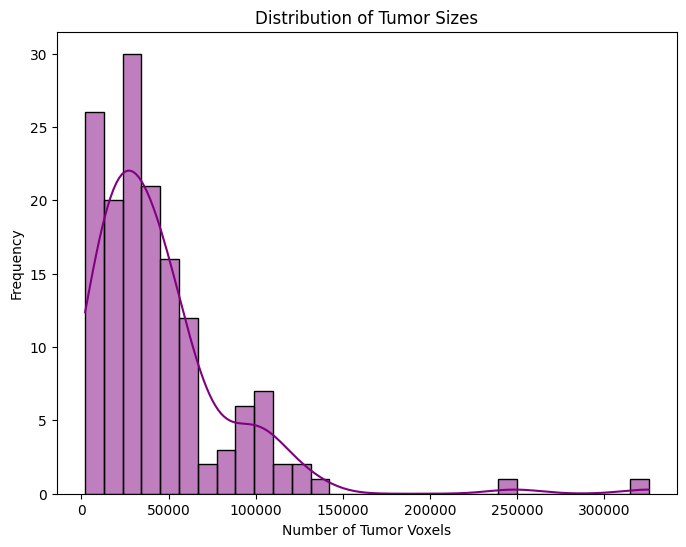

In [29]:
# Calculate tumor sizes
tumor_sizes = [counts.get(1, 0) + counts.get(2, 0) for counts in mask_voxel_counts]

# Plot distribution
plt.figure(figsize=(8, 6))
sns.histplot(tumor_sizes, bins=30, kde=True, color='purple')
plt.title('Distribution of Tumor Sizes')
plt.xlabel('Number of Tumor Voxels')
plt.ylabel('Frequency')
plt.show()

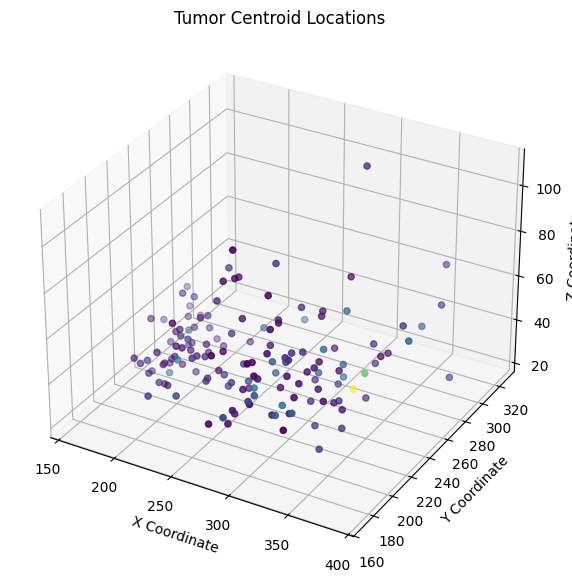

In [30]:
# Initialize lists
tumor_sizes = []
tumor_locations = []

for patient_id in patient_folders:
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    mask_img = nib.load(mask_path)
    mask_data = mask_img.get_fdata().astype(int)

    # Calculate tumor size (number of voxels in tumor classes)
    tumor_voxels = mask_data > 0
    size = np.sum(tumor_voxels)
    tumor_sizes.append(size)

    # Calculate tumor centroid
    coords = np.column_stack(np.where(mask_data > 0))
    if coords.size > 0:
        centroid = coords.mean(axis=0)
        tumor_locations.append(centroid)
    else:
        tumor_locations.append([np.nan, np.nan, np.nan])

# Convert to DataFrame
eda_df = pd.DataFrame({
    'Patient_ID': patient_folders,
    'Tumor_Size': tumor_sizes,
    'Centroid_X': [loc[0] for loc in tumor_locations],
    'Centroid_Y': [loc[1] for loc in tumor_locations],
    'Centroid_Z': [loc[2] for loc in tumor_locations],
})

# 3D Scatter plot of tumor centroids
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(eda_df['Centroid_X'], eda_df['Centroid_Y'], eda_df['Centroid_Z'], c=eda_df['Tumor_Size'])
ax.set_title('Tumor Centroid Locations')
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
plt.show()

**EDA: Understand class distribution (Background, GTVp, GTVn)**

In [48]:
# Aggregate mask voxel counts
class_counts = {}
for counts in mask_voxel_counts:
    for k, v in counts.items():
        class_counts[k] = class_counts.get(k, 0) + v

# Calculate total voxels
total_voxels = sum(class_counts.values())

# Calculate percentages
class_percentages = {int(k): (v / total_voxels) * 100 for k, v in class_counts.items()}

# Define class labels
class_labels = {
    0: 'Background',
    1: 'GTVp',
    2: 'GTVn'
}

# Create a DataFrame for class distribution
class_df = pd.DataFrame({
    'Class': [class_labels.get(cls, f'Class {cls}') for cls in class_percentages.keys()],
    'Percentage (%)': [round(pct, 4) for pct in class_percentages.values()]
})

# Display the DataFrame
class_df.round(2)

,Class,Percentage (%)
0,Background,99.81
1,GTVp,0.09
2,GTVn,0.10


**EDA: Plot samples to check quality and type of data**

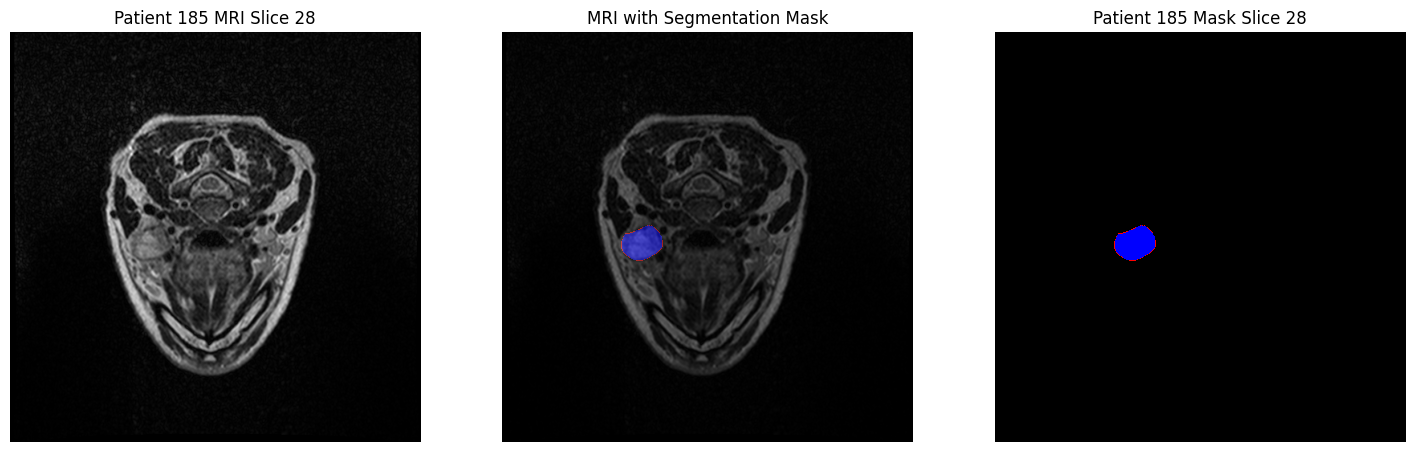

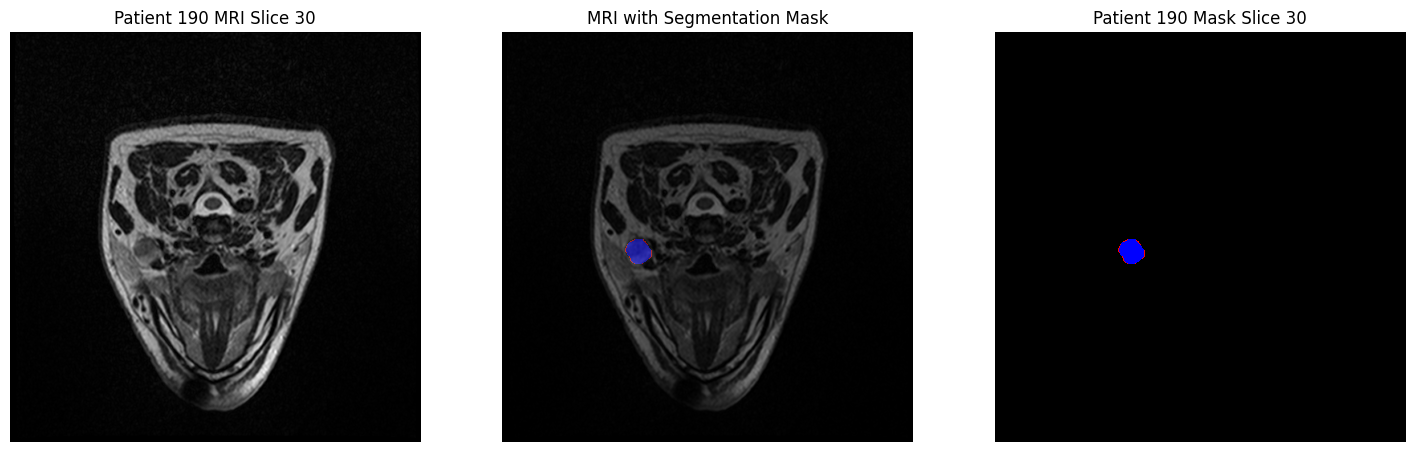

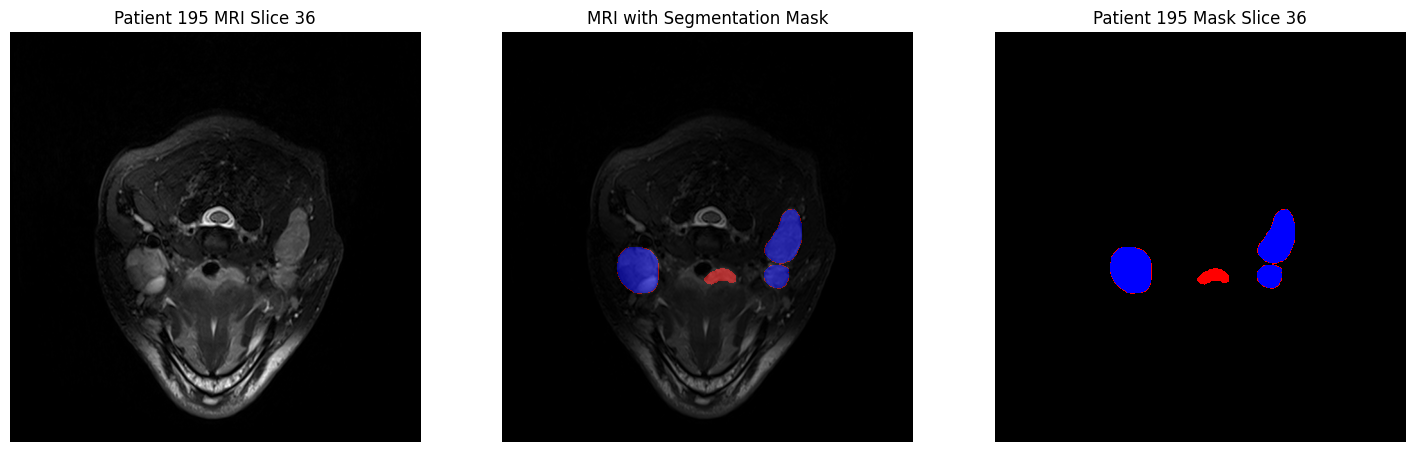

In [32]:
def plot_sample(patient_id, slice_index=None):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Load data
    mri_data = nib.load(mri_path).get_fdata()
    mask_data = nib.load(mask_path).get_fdata().astype(int)
    
    # Select the middle slice
    slice_index = mri_data.shape[2] // 2
    mri_slice = mri_data[:, :, slice_index].T
    mask_slice = mask_data[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. MRI Image
    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    axes[0].set_title(f'Patient {patient_id} MRI Slice {slice_index}')
    axes[0].axis('off')
    
    # 2. MRI with Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')
    
    # 3. Mask Only
    im = axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    axes[2].set_title(f'Patient {patient_id} Mask Slice {slice_index}')
    axes[2].axis('off')

    plt.show()

# Plot samples from a few patients
patient_ids = ['185', '190', '195']
for pid in patient_ids:
    plot_sample(pid)

# **Step 3: Data Preprocessing**

**Create data dictionary**

In [33]:
def create_data_dicts(train_dir):
    """
    Creates data dictionaries for MONAI.
    """
    data_dicts = [
        {
            "image": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_T2.nii.gz'),
            "label": os.path.join(train_dir, pid, 'preRT', f'{pid}_preRT_mask.nii.gz'),
        }
        for pid in patient_folders
    ]
    return data_dicts

# Create data dictionaries
data_dicts = create_data_dicts(TRAIN_DIR)

**Split the dataset into training and validation (80/20)**

In [34]:
# Split data into training and validation sets
train_files = data_dicts[:120]
val_files = data_dicts[120:]
print(f"Training samples: {len(train_files)}, Validation samples: {len(val_files)}")

Training samples: 120, Validation samples: 30


**Transform images**

In [35]:
# Transform the images for training
train_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
            ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image"),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),

        # Randomly crop based on labels
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 32),
            pos=1,
            neg=1,
            num_samples=NUM_SAMPLES,
            image_key="image",
            image_threshold=0,
        ),
        
        # Apply random flips
        RandFlipd(keys=["image", "label"], spatial_axis=[0], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[1], prob=0.10),
        RandFlipd(keys=["image", "label"], spatial_axis=[2], prob=0.10),

        # Apply random rotations
        RandRotate90d(keys=["image", "label"], prob=0.10, max_k=3),

        # Random intensity shift
        RandShiftIntensityd(keys=["image"], offsets=0.10, prob=0.50),
    ]
)

# Transform the images for validation
val_transforms = Compose(
    [
        # Load images and labels
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),

        # Scale image intensity
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),

        # Crop to remove background
        CropForegroundd(keys=["image", "label"], source_key="image"),

        # Reorient to RAS standard
        Orientationd(keys=["image", "label"], axcodes="RAS"),

        # Resample to target spacing
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.5, 1.5, 2.0),
            mode=("bilinear", "nearest"),
        ),

        # Convert to PyTorch tensors
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


**Create datasets**

In [36]:
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)

Loading dataset: 100%|██████████| 30/30 [01:06<00:00,  2.21s/it]


**Create DataLoaders**

In [37]:
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=3, shuffle=True)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)


Train Batch 1:


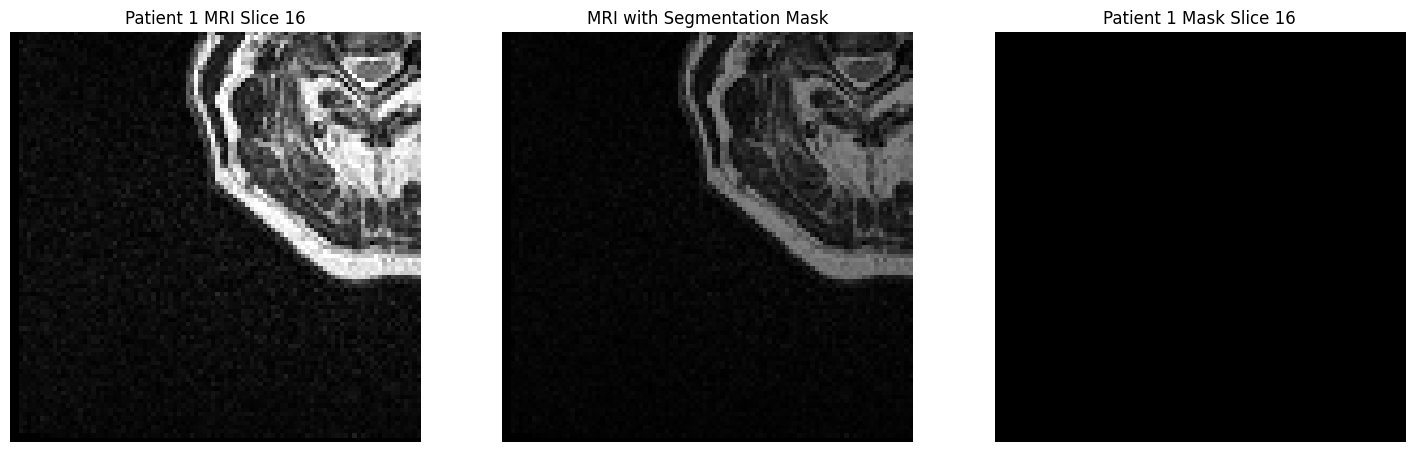

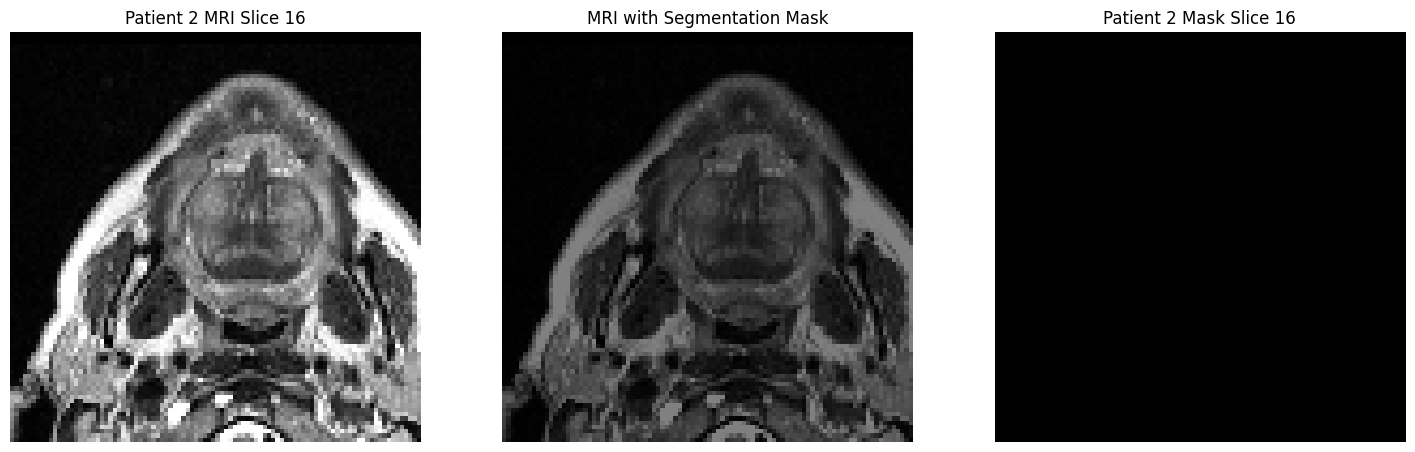


Train Batch 2:


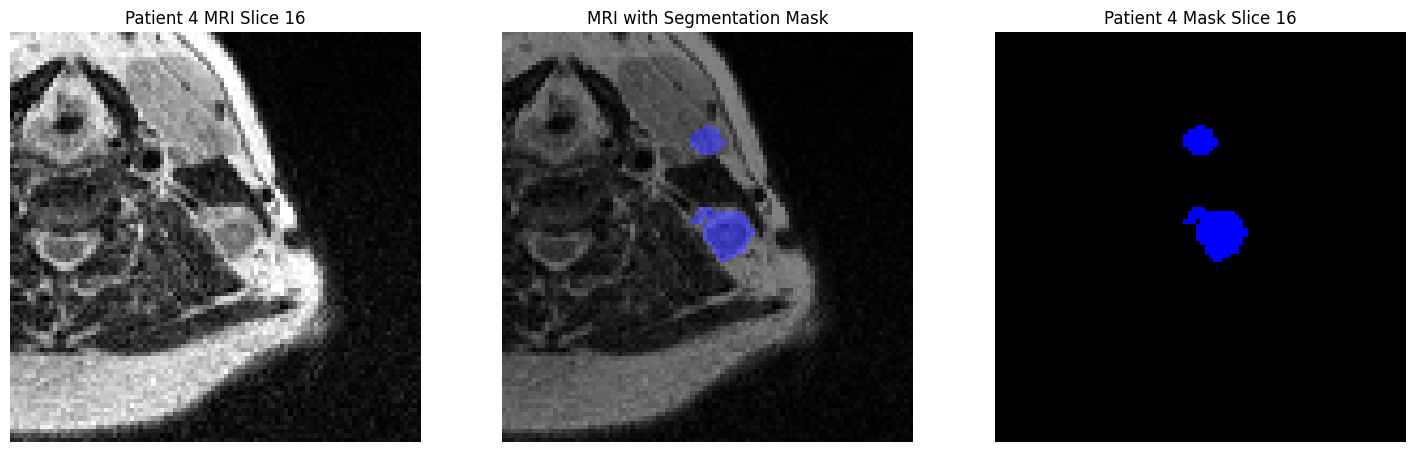

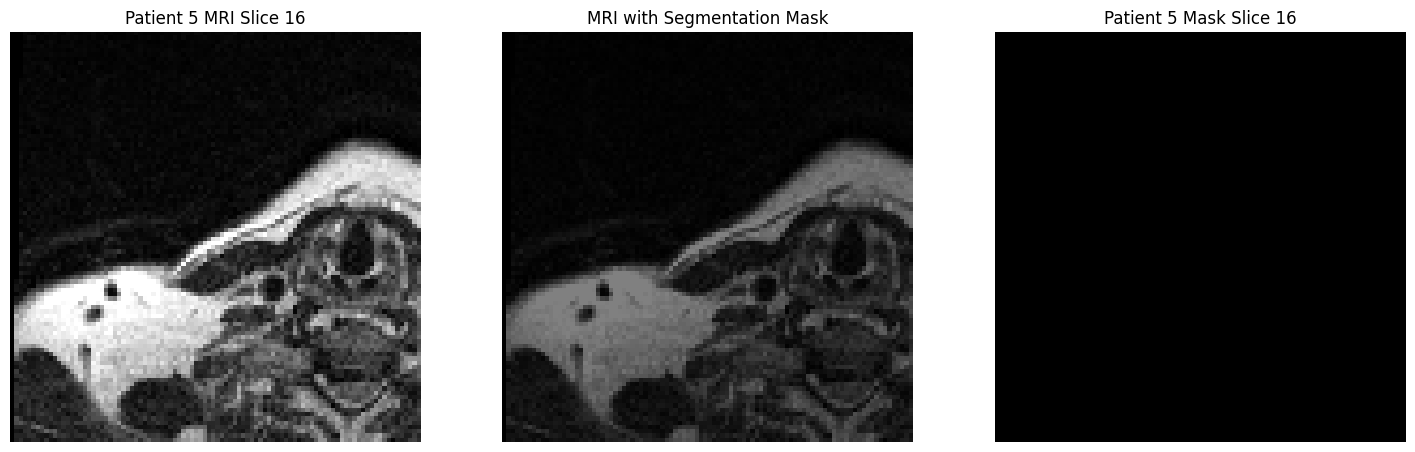


Validation Batch 1:


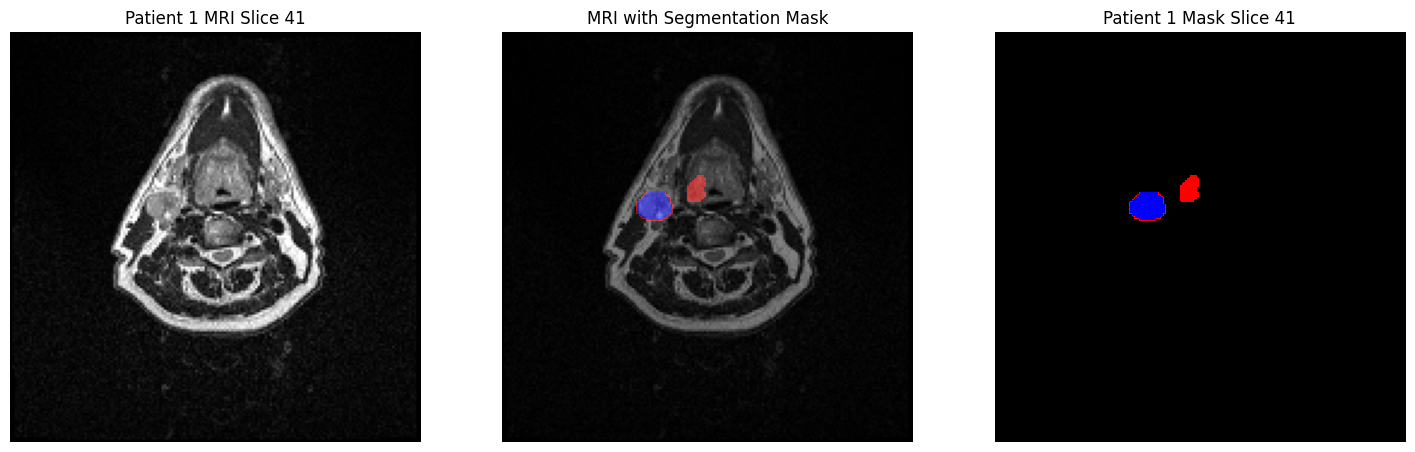

In [38]:
def plot_dataloader_sample(image_tensor, label_tensor, patient_id=None, slice_index=None):
    """
    Plots MRI image, MRI with segmentation mask overlay, and mask only.
    """
    image_np = image_tensor.cpu().numpy()
    label_np = label_tensor.cpu().numpy()

    if image_np.shape[0] == 1:
        image_np = np.squeeze(image_np, axis=0)

    if label_np.ndim == 4 and label_np.shape[0] == 1:
        label_np = np.squeeze(label_np, axis=0)

    if slice_index is None:
        slice_index = image_np.shape[2] // 2

    mri_slice = image_np[:, :, slice_index].T
    mask_slice = label_np[:, :, slice_index].T

    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(mri_slice, cmap='gray', origin='lower')
    title1 = f'Patient {patient_id} MRI Slice {slice_index}' if patient_id else f'MRI Slice {slice_index}'
    axes[0].set_title(title1)
    axes[0].axis('off')

    axes[1].imshow(mri_slice, cmap='gray', origin='lower')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='lower')
    axes[1].set_title('MRI with Segmentation Mask')
    axes[1].axis('off')

    axes[2].imshow(mask_slice, cmap=cmap, norm=norm, origin='lower')
    title3 = f'Patient {patient_id} Mask Slice {slice_index}' if patient_id else f'Mask Slice {slice_index}'
    axes[2].set_title(title3)
    axes[2].axis('off')

    plt.show()

def visualize_dataloader_samples(dataloader, num_batches=1, samples_per_batch=2, mode='Train'):
    """
    Visualizes samples from the dataloader.
    """
    for batch_idx, batch_data in enumerate(dataloader):
        if batch_idx >= num_batches:
            break

        images = batch_data["image"]
        labels = batch_data["label"]

        batch_size = images.shape[0]
        print(f"\n{mode} Batch {batch_idx + 1}:")
        for i in range(min(samples_per_batch, batch_size)):
            image = images[i]
            label = labels[i]
            patient_id = f"{batch_idx * dataloader.batch_size + i + 1}"
            plot_dataloader_sample(image, label, patient_id=patient_id)

# Example visualization
visualize_dataloader_samples(train_loader, num_batches=2, samples_per_batch=2, mode='Train')
visualize_dataloader_samples(val_loader, num_batches=1, samples_per_batch=1, mode='Validation')

**Prepare for usage of GPU**

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# **Step 5: Build Model**

**Initialize SwinUNETR Model**

In [40]:
model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=3,
    feature_size=48,
    use_checkpoint=True,
).to(device)

/cluster/home/bjorneme/.conda/envs/master_thesis/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


# **Step 6: Train and Validate Model**

**Define Loss, Optimizer, and Metrics**

In [41]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scaler = torch.cuda.amp.GradScaler()

post_label = AsDiscrete(to_onehot=NUM_CLASSES)
post_pred = AsDiscrete(argmax=True, to_onehot=NUM_CLASSES)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

/tmp/ipykernel_2478620/567529329.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


**Training Loop**

In [42]:
# Post-processing for metrics
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)

# Initialize Dice metric
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

# Initialize lists to store loss values
train_losses = []
val_losses = []
dice_scores = []

best_dice = 0.0  # Initialize best Dice score
best_epoch = 0  # To track which epoch had the best Dice score

# Initialize the scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',  # Because higher Dice score is better
    factor=SCHEDULER_FACTOR,
    patience=SCHEDULER_PATIENCE,
    verbose=True,
    min_lr=SCHEDULER_MIN_LR
)

# Training Loop
for epoch in range(NUM_EPOCHS):

    # ----------- Training Phase -----------
    model.train()
    epoch_loss = 0.0
    step = 0
    progress_bar = tqdm(train_loader, desc=f"Training epoch {epoch+1}/{NUM_EPOCHS}")

    for batch_data in progress_bar:
        step += 1

        # Retrieve training samples
        inputs = batch_data["image"].to(device)
        labels = batch_data["label"].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        with torch.amp.autocast(str(device)):

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = loss_function(outputs, labels) / ACCUMULATION_STEPS

        # Backward pass
        scaler.scale(loss).backward()

        # Calculate epoch loss
        epoch_loss += loss.item() * ACCUMULATION_STEPS

        if step % ACCUMULATION_STEPS == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        
        # Update progress bar
        progress_bar.set_postfix({"Loss": loss.item()*ACCUMULATION_STEPS})

    # Calculate average epoch loss
    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)


    # ----------- Validation Phase -----------
    model.eval()
    val_loss = 0.0
    dice_metric.reset()
    progress_bar = tqdm(val_loader, desc=f"Validation epoch {epoch+1}/{NUM_EPOCHS}")

    with torch.no_grad():
        for val_batch in progress_bar:

            # Retrieve validation samples
            val_inputs = val_batch["image"].cuda()
            val_labels = val_batch["label"].cuda()

            with torch.amp.autocast(str(device)):
                # Forward pass with sliding window inference for large images
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)

                # Compute validation loss
                loss = loss_function(val_outputs, val_labels)
                val_loss += loss.item()

            # Post-processing for Dice metric
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)

            # Update progress bar
            progress_bar.set_postfix({"Loss": loss.item()})
    
    # Calculate average validation loss and Dice score for the epoch
    avg_val_loss = val_loss / len(val_loader)
    dice_score = dice_metric.aggregate().item()
    dice_metric.reset()

    # Save losses
    val_losses.append(avg_val_loss)
    dice_scores.append(dice_score)

    # Step the scheduler based on validation Dice score
    scheduler.step(dice_score)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {avg_epoch_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Dice Score: {dice_score:.4f}")


    # ----------- Model Checkpointing -----------
    if dice_score > best_dice:
        best_dice = dice_score
        best_epoch = epoch + 1
        torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
        print(f"New best Dice score! Model saved at epoch {best_epoch} with Dice: {best_dice:.4f}")
    else:
        print(f"No improvement in Dice score this epoch.")


/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Training epoch 1/250:   0%|          | 0/40 [00:00<?, ?it/s]/cluster/home/bjorneme/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:1399: FutureWarning: `torch.cpu.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cpu', args...)` instead.
  with device_autocast_ctx, torch.cpu.amp.autocast(**cpu_autocast_kwargs), recompute_context:  # type: ignore[attr-defined]
Validation epoch 1/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=1.62]


Epoch [1/250], Train Loss: 1.8297, Val Loss: 1.5770, Dice Score: 0.3574
New best Dice score! Model saved at epoch 1 with Dice: 0.3574


Validation epoch 2/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=1.5] 


Epoch [2/250], Train Loss: 1.4946, Val Loss: 1.4538, Dice Score: 0.3691
New best Dice score! Model saved at epoch 2 with Dice: 0.3691


Validation epoch 3/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.43]


Epoch [3/250], Train Loss: 1.3740, Val Loss: 1.3865, Dice Score: 0.3709
New best Dice score! Model saved at epoch 3 with Dice: 0.3709


Validation epoch 4/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.39]


Epoch [4/250], Train Loss: 1.2984, Val Loss: 1.3386, Dice Score: 0.3714
New best Dice score! Model saved at epoch 4 with Dice: 0.3714


Validation epoch 5/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.35]


Epoch [5/250], Train Loss: 1.2544, Val Loss: 1.2990, Dice Score: 0.3717
New best Dice score! Model saved at epoch 5 with Dice: 0.3717


Validation epoch 6/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=1.32]


Epoch [6/250], Train Loss: 1.2118, Val Loss: 1.2669, Dice Score: 0.3719
New best Dice score! Model saved at epoch 6 with Dice: 0.3719


Validation epoch 7/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.3] 


Epoch [7/250], Train Loss: 1.1860, Val Loss: 1.2524, Dice Score: 0.3719
New best Dice score! Model saved at epoch 7 with Dice: 0.3719


Validation epoch 8/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.28]


Epoch [8/250], Train Loss: 1.1573, Val Loss: 1.2239, Dice Score: 0.3719
New best Dice score! Model saved at epoch 8 with Dice: 0.3719


Validation epoch 9/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.26]


Epoch [9/250], Train Loss: 1.1312, Val Loss: 1.2032, Dice Score: 0.3719
New best Dice score! Model saved at epoch 9 with Dice: 0.3719


Validation epoch 10/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=1.25]


Epoch [10/250], Train Loss: 1.1101, Val Loss: 1.1879, Dice Score: 0.3719
New best Dice score! Model saved at epoch 10 with Dice: 0.3719


Validation epoch 11/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=1.23]


Epoch [11/250], Train Loss: 1.0916, Val Loss: 1.1753, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 12/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=1.21]


Epoch [12/250], Train Loss: 1.0727, Val Loss: 1.1555, Dice Score: 0.3719
New best Dice score! Model saved at epoch 12 with Dice: 0.3719


Validation epoch 13/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.2] 


Epoch [13/250], Train Loss: 1.0466, Val Loss: 1.1445, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 14/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.18]


Epoch [14/250], Train Loss: 1.0312, Val Loss: 1.1201, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 15/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.16]


Epoch [15/250], Train Loss: 1.0134, Val Loss: 1.1006, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 16/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.12]


Epoch [16/250], Train Loss: 0.9953, Val Loss: 1.0750, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 17/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.11] 


Epoch [17/250], Train Loss: 0.9808, Val Loss: 1.0616, Dice Score: 0.3718
No improvement in Dice score this epoch.


Validation epoch 18/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=1.08] 


Epoch [18/250], Train Loss: 0.9698, Val Loss: 1.0369, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 19/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=1.05] 


Epoch [19/250], Train Loss: 0.9562, Val Loss: 1.0193, Dice Score: 0.3718
No improvement in Dice score this epoch.


Validation epoch 20/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.04] 


Epoch [20/250], Train Loss: 0.9439, Val Loss: 1.0106, Dice Score: 0.3718
No improvement in Dice score this epoch.


Validation epoch 21/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.02] 


Epoch [21/250], Train Loss: 0.9325, Val Loss: 0.9964, Dice Score: 0.3718
No improvement in Dice score this epoch.


Validation epoch 22/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=1.01] 


Epoch [22/250], Train Loss: 0.9226, Val Loss: 0.9784, Dice Score: 0.3718
No improvement in Dice score this epoch.


Validation epoch 23/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.993]


Epoch [23/250], Train Loss: 0.9127, Val Loss: 0.9708, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 24/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.979]


Epoch [24/250], Train Loss: 0.9002, Val Loss: 0.9563, Dice Score: 0.3720
New best Dice score! Model saved at epoch 24 with Dice: 0.3720


Validation epoch 25/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.957]


Epoch [25/250], Train Loss: 0.8926, Val Loss: 0.9442, Dice Score: 0.3719
No improvement in Dice score this epoch.


Validation epoch 26/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.949]


Epoch [26/250], Train Loss: 0.8835, Val Loss: 0.9377, Dice Score: 0.3730
New best Dice score! Model saved at epoch 26 with Dice: 0.3730


Validation epoch 27/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.941]


Epoch [27/250], Train Loss: 0.8748, Val Loss: 0.9244, Dice Score: 0.3723
No improvement in Dice score this epoch.


Validation epoch 28/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.942]


Epoch [28/250], Train Loss: 0.8666, Val Loss: 0.9254, Dice Score: 0.3745
New best Dice score! Model saved at epoch 28 with Dice: 0.3745


Validation epoch 29/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.93] 


Epoch [29/250], Train Loss: 0.8606, Val Loss: 0.9148, Dice Score: 0.3848
New best Dice score! Model saved at epoch 29 with Dice: 0.3848


Validation epoch 30/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.923]


Epoch [30/250], Train Loss: 0.8546, Val Loss: 0.9085, Dice Score: 0.3714
No improvement in Dice score this epoch.


Validation epoch 31/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.923]


Epoch [31/250], Train Loss: 0.8486, Val Loss: 0.9123, Dice Score: 0.3708
No improvement in Dice score this epoch.


Validation epoch 32/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.904]


Epoch [32/250], Train Loss: 0.8402, Val Loss: 0.8893, Dice Score: 0.3741
No improvement in Dice score this epoch.


Validation epoch 33/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.884]


Epoch [33/250], Train Loss: 0.8323, Val Loss: 0.8764, Dice Score: 0.3721
No improvement in Dice score this epoch.


Validation epoch 34/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.914]


Epoch [34/250], Train Loss: 0.8292, Val Loss: 0.9062, Dice Score: 0.3837
No improvement in Dice score this epoch.


Validation epoch 35/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.886]


Epoch [35/250], Train Loss: 0.8247, Val Loss: 0.8800, Dice Score: 0.3950
New best Dice score! Model saved at epoch 35 with Dice: 0.3950


Validation epoch 36/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.87] 


Epoch [36/250], Train Loss: 0.8202, Val Loss: 0.8627, Dice Score: 0.3721
No improvement in Dice score this epoch.


Validation epoch 37/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.871]


Epoch [37/250], Train Loss: 0.8169, Val Loss: 0.8586, Dice Score: 0.3794
No improvement in Dice score this epoch.


Validation epoch 38/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.849]


Epoch [38/250], Train Loss: 0.8091, Val Loss: 0.8403, Dice Score: 0.4103
New best Dice score! Model saved at epoch 38 with Dice: 0.4103


Validation epoch 39/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.86] 


Epoch [39/250], Train Loss: 0.8024, Val Loss: 0.8615, Dice Score: 0.3698
No improvement in Dice score this epoch.


Validation epoch 40/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.859]


Epoch [40/250], Train Loss: 0.7993, Val Loss: 0.8472, Dice Score: 0.3988
No improvement in Dice score this epoch.


Validation epoch 41/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.872]


Epoch [41/250], Train Loss: 0.7938, Val Loss: 0.8577, Dice Score: 0.3898
No improvement in Dice score this epoch.


Validation epoch 42/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.859]


Epoch [42/250], Train Loss: 0.7910, Val Loss: 0.8463, Dice Score: 0.3931
No improvement in Dice score this epoch.


Validation epoch 43/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.84] 


Epoch [43/250], Train Loss: 0.7868, Val Loss: 0.8344, Dice Score: 0.4109
New best Dice score! Model saved at epoch 43 with Dice: 0.4109


Validation epoch 44/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.812]


Epoch [44/250], Train Loss: 0.7837, Val Loss: 0.8138, Dice Score: 0.3777
No improvement in Dice score this epoch.


Validation epoch 45/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.822]


Epoch [45/250], Train Loss: 0.7838, Val Loss: 0.8147, Dice Score: 0.4022
No improvement in Dice score this epoch.


Validation epoch 46/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.837]


Epoch [46/250], Train Loss: 0.7769, Val Loss: 0.8250, Dice Score: 0.4073
No improvement in Dice score this epoch.


Validation epoch 47/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.82] 


Epoch [47/250], Train Loss: 0.7711, Val Loss: 0.8113, Dice Score: 0.4090
No improvement in Dice score this epoch.


Validation epoch 48/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.806]


Epoch [48/250], Train Loss: 0.7690, Val Loss: 0.8047, Dice Score: 0.3986
No improvement in Dice score this epoch.


Validation epoch 49/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.826]


Epoch [49/250], Train Loss: 0.7666, Val Loss: 0.8253, Dice Score: 0.3751
No improvement in Dice score this epoch.


Validation epoch 50/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.824]


Epoch [50/250], Train Loss: 0.7632, Val Loss: 0.8173, Dice Score: 0.4023
No improvement in Dice score this epoch.


Validation epoch 51/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.798]


Epoch [51/250], Train Loss: 0.7589, Val Loss: 0.7974, Dice Score: 0.4045
No improvement in Dice score this epoch.


Validation epoch 52/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.817]


Epoch [52/250], Train Loss: 0.7592, Val Loss: 0.8173, Dice Score: 0.3720
No improvement in Dice score this epoch.


Validation epoch 53/250: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.811]


Epoch [53/250], Train Loss: 0.7535, Val Loss: 0.7995, Dice Score: 0.4250
New best Dice score! Model saved at epoch 53 with Dice: 0.4250


Validation epoch 54/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.81] 


Epoch [54/250], Train Loss: 0.7512, Val Loss: 0.8014, Dice Score: 0.4089
No improvement in Dice score this epoch.


Validation epoch 55/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.779]


Epoch [55/250], Train Loss: 0.7453, Val Loss: 0.7804, Dice Score: 0.4257
New best Dice score! Model saved at epoch 55 with Dice: 0.4257


Validation epoch 56/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.78] 


Epoch [56/250], Train Loss: 0.7420, Val Loss: 0.7763, Dice Score: 0.4337
New best Dice score! Model saved at epoch 56 with Dice: 0.4337


Validation epoch 57/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.809]


Epoch [57/250], Train Loss: 0.7413, Val Loss: 0.7966, Dice Score: 0.4293
No improvement in Dice score this epoch.


Validation epoch 58/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.789]


Epoch [58/250], Train Loss: 0.7366, Val Loss: 0.7893, Dice Score: 0.4336
No improvement in Dice score this epoch.


Validation epoch 59/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.773]


Epoch [59/250], Train Loss: 0.7320, Val Loss: 0.7700, Dice Score: 0.4723
New best Dice score! Model saved at epoch 59 with Dice: 0.4723


Validation epoch 60/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.776]


Epoch [60/250], Train Loss: 0.7302, Val Loss: 0.7696, Dice Score: 0.4731
New best Dice score! Model saved at epoch 60 with Dice: 0.4731


Validation epoch 61/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.764]


Epoch [61/250], Train Loss: 0.7258, Val Loss: 0.7697, Dice Score: 0.4308
No improvement in Dice score this epoch.


Validation epoch 62/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.778]


Epoch [62/250], Train Loss: 0.7287, Val Loss: 0.7847, Dice Score: 0.3743
No improvement in Dice score this epoch.


Validation epoch 63/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.771]


Epoch [63/250], Train Loss: 0.7280, Val Loss: 0.7667, Dice Score: 0.4724
No improvement in Dice score this epoch.


Validation epoch 64/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.766]


Epoch [64/250], Train Loss: 0.7217, Val Loss: 0.7603, Dice Score: 0.4647
No improvement in Dice score this epoch.


Validation epoch 65/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.769]


Epoch [65/250], Train Loss: 0.7143, Val Loss: 0.7664, Dice Score: 0.4741
New best Dice score! Model saved at epoch 65 with Dice: 0.4741


Validation epoch 66/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.777]


Epoch [66/250], Train Loss: 0.7086, Val Loss: 0.7801, Dice Score: 0.4414
No improvement in Dice score this epoch.


Validation epoch 67/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.791]


Epoch [67/250], Train Loss: 0.7061, Val Loss: 0.7900, Dice Score: 0.4123
No improvement in Dice score this epoch.


Validation epoch 68/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.766]


Epoch [68/250], Train Loss: 0.7032, Val Loss: 0.7622, Dice Score: 0.4385
No improvement in Dice score this epoch.


Validation epoch 69/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.762]


Epoch [69/250], Train Loss: 0.7007, Val Loss: 0.7506, Dice Score: 0.4601
No improvement in Dice score this epoch.


Validation epoch 70/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.775]


Epoch [70/250], Train Loss: 0.6897, Val Loss: 0.7737, Dice Score: 0.4277
No improvement in Dice score this epoch.


Validation epoch 71/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.77] 


Epoch [71/250], Train Loss: 0.6947, Val Loss: 0.7567, Dice Score: 0.4388
No improvement in Dice score this epoch.


Validation epoch 72/250: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.759]


Epoch [72/250], Train Loss: 0.6889, Val Loss: 0.7448, Dice Score: 0.5080
New best Dice score! Model saved at epoch 72 with Dice: 0.5080


Validation epoch 73/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.746]


Epoch [73/250], Train Loss: 0.6913, Val Loss: 0.7383, Dice Score: 0.4837
No improvement in Dice score this epoch.


Validation epoch 74/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.78] 


Epoch [74/250], Train Loss: 0.6741, Val Loss: 0.7651, Dice Score: 0.4432
No improvement in Dice score this epoch.


Validation epoch 75/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.769]


Epoch [75/250], Train Loss: 0.6713, Val Loss: 0.7562, Dice Score: 0.4760
No improvement in Dice score this epoch.


Validation epoch 76/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.761]


Epoch [76/250], Train Loss: 0.6793, Val Loss: 0.7446, Dice Score: 0.4795
No improvement in Dice score this epoch.


Validation epoch 77/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.778]


Epoch [77/250], Train Loss: 0.6699, Val Loss: 0.7757, Dice Score: 0.4172
No improvement in Dice score this epoch.


Validation epoch 78/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.765]


Epoch [78/250], Train Loss: 0.6765, Val Loss: 0.7412, Dice Score: 0.4625
No improvement in Dice score this epoch.


Validation epoch 79/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.751]


Epoch [79/250], Train Loss: 0.6666, Val Loss: 0.7400, Dice Score: 0.4589
No improvement in Dice score this epoch.


Validation epoch 80/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.738]


Epoch [80/250], Train Loss: 0.6620, Val Loss: 0.7330, Dice Score: 0.4959
No improvement in Dice score this epoch.


Validation epoch 81/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.755]


Epoch [81/250], Train Loss: 0.6533, Val Loss: 0.7479, Dice Score: 0.4516
No improvement in Dice score this epoch.


Validation epoch 82/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.757]


Epoch [82/250], Train Loss: 0.6705, Val Loss: 0.7406, Dice Score: 0.4848
No improvement in Dice score this epoch.


Validation epoch 83/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.734]


Epoch [83/250], Train Loss: 0.6682, Val Loss: 0.7266, Dice Score: 0.4594
No improvement in Dice score this epoch.


Validation epoch 84/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.75] 


Epoch [84/250], Train Loss: 0.6475, Val Loss: 0.7316, Dice Score: 0.4876
No improvement in Dice score this epoch.


Validation epoch 85/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.752]


Epoch [85/250], Train Loss: 0.6479, Val Loss: 0.7341, Dice Score: 0.4674
No improvement in Dice score this epoch.


Validation epoch 86/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.73] 


Epoch [86/250], Train Loss: 0.6448, Val Loss: 0.7156, Dice Score: 0.5094
New best Dice score! Model saved at epoch 86 with Dice: 0.5094


Validation epoch 87/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.728]


Epoch [87/250], Train Loss: 0.6385, Val Loss: 0.7035, Dice Score: 0.5407
New best Dice score! Model saved at epoch 87 with Dice: 0.5407


Validation epoch 88/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.734]


Epoch [88/250], Train Loss: 0.6335, Val Loss: 0.7263, Dice Score: 0.4989
No improvement in Dice score this epoch.


Validation epoch 89/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.724]


Epoch [89/250], Train Loss: 0.6349, Val Loss: 0.7089, Dice Score: 0.5208
No improvement in Dice score this epoch.


Validation epoch 90/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.737]


Epoch [90/250], Train Loss: 0.6260, Val Loss: 0.7262, Dice Score: 0.4773
No improvement in Dice score this epoch.


Validation epoch 91/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.736]


Epoch [91/250], Train Loss: 0.6291, Val Loss: 0.7240, Dice Score: 0.4755
No improvement in Dice score this epoch.


Validation epoch 92/250: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, Loss=0.725]


Epoch [92/250], Train Loss: 0.6232, Val Loss: 0.7142, Dice Score: 0.5020
No improvement in Dice score this epoch.


Validation epoch 93/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.719]


Epoch [93/250], Train Loss: 0.6221, Val Loss: 0.6956, Dice Score: 0.5547
New best Dice score! Model saved at epoch 93 with Dice: 0.5547


Validation epoch 94/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.719]


Epoch [94/250], Train Loss: 0.6209, Val Loss: 0.7083, Dice Score: 0.4930
No improvement in Dice score this epoch.


Validation epoch 95/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.721]


Epoch [95/250], Train Loss: 0.6185, Val Loss: 0.7098, Dice Score: 0.4848
No improvement in Dice score this epoch.


Validation epoch 96/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.721]


Epoch [96/250], Train Loss: 0.6178, Val Loss: 0.6965, Dice Score: 0.5078
No improvement in Dice score this epoch.


Validation epoch 97/250: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.718]


Epoch [97/250], Train Loss: 0.6178, Val Loss: 0.7079, Dice Score: 0.4907
No improvement in Dice score this epoch.


Validation epoch 98/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.718]


Epoch [98/250], Train Loss: 0.6092, Val Loss: 0.6978, Dice Score: 0.4948
No improvement in Dice score this epoch.


Validation epoch 99/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.712]


Epoch [99/250], Train Loss: 0.6145, Val Loss: 0.6923, Dice Score: 0.5274
No improvement in Dice score this epoch.


Validation epoch 100/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.722]


Epoch [100/250], Train Loss: 0.6009, Val Loss: 0.7083, Dice Score: 0.4907
No improvement in Dice score this epoch.


Validation epoch 101/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.714]


Epoch [101/250], Train Loss: 0.6033, Val Loss: 0.6978, Dice Score: 0.5196
No improvement in Dice score this epoch.


Validation epoch 102/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.714]


Epoch [102/250], Train Loss: 0.5992, Val Loss: 0.6913, Dice Score: 0.5208
No improvement in Dice score this epoch.


Validation epoch 103/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.722]


Epoch [103/250], Train Loss: 0.6012, Val Loss: 0.7045, Dice Score: 0.5180
No improvement in Dice score this epoch.


Validation epoch 104/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.708]


Epoch [104/250], Train Loss: 0.5958, Val Loss: 0.6885, Dice Score: 0.5215
No improvement in Dice score this epoch.


Validation epoch 105/250: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.711]


Epoch [105/250], Train Loss: 0.6039, Val Loss: 0.6979, Dice Score: 0.4911
No improvement in Dice score this epoch.


Validation epoch 106/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.708]


Epoch [106/250], Train Loss: 0.5995, Val Loss: 0.6780, Dice Score: 0.5282
No improvement in Dice score this epoch.


Validation epoch 107/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.701]


Epoch [107/250], Train Loss: 0.5931, Val Loss: 0.6707, Dice Score: 0.5356
No improvement in Dice score this epoch.


Validation epoch 108/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.716]


Epoch [108/250], Train Loss: 0.5976, Val Loss: 0.6980, Dice Score: 0.4939
No improvement in Dice score this epoch.


Validation epoch 109/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.715]


Epoch [109/250], Train Loss: 0.5935, Val Loss: 0.6903, Dice Score: 0.4952
No improvement in Dice score this epoch.


Validation epoch 110/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.705]


Epoch [110/250], Train Loss: 0.5963, Val Loss: 0.6837, Dice Score: 0.5092
No improvement in Dice score this epoch.


Validation epoch 111/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.723]


Epoch [111/250], Train Loss: 0.5820, Val Loss: 0.6971, Dice Score: 0.4844
No improvement in Dice score this epoch.


Validation epoch 112/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.701]


Epoch [112/250], Train Loss: 0.5862, Val Loss: 0.6661, Dice Score: 0.5513
No improvement in Dice score this epoch.


Validation epoch 113/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.707]


Epoch [113/250], Train Loss: 0.5813, Val Loss: 0.6921, Dice Score: 0.4893
No improvement in Dice score this epoch.


Validation epoch 114/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.703]


Epoch [114/250], Train Loss: 0.5822, Val Loss: 0.6782, Dice Score: 0.5084
No improvement in Dice score this epoch.


Validation epoch 115/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.698]


Epoch [115/250], Train Loss: 0.5882, Val Loss: 0.6614, Dice Score: 0.5421
No improvement in Dice score this epoch.


Validation epoch 116/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.705]


Epoch [116/250], Train Loss: 0.5768, Val Loss: 0.6772, Dice Score: 0.4993
No improvement in Dice score this epoch.


Validation epoch 117/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.699]


Epoch [117/250], Train Loss: 0.5725, Val Loss: 0.6770, Dice Score: 0.5119
No improvement in Dice score this epoch.


Validation epoch 118/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.703]


Epoch [118/250], Train Loss: 0.5746, Val Loss: 0.6855, Dice Score: 0.4814
No improvement in Dice score this epoch.


Validation epoch 119/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.709]


Epoch [119/250], Train Loss: 0.5748, Val Loss: 0.6908, Dice Score: 0.4884
No improvement in Dice score this epoch.


Validation epoch 120/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.696]


Epoch [120/250], Train Loss: 0.5713, Val Loss: 0.6773, Dice Score: 0.5209
No improvement in Dice score this epoch.


Validation epoch 121/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.711]


Epoch [121/250], Train Loss: 0.5616, Val Loss: 0.6981, Dice Score: 0.4832
No improvement in Dice score this epoch.


Validation epoch 122/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.711]


Epoch [122/250], Train Loss: 0.5640, Val Loss: 0.6969, Dice Score: 0.4878
No improvement in Dice score this epoch.


Validation epoch 123/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.69] 


Epoch [123/250], Train Loss: 0.5629, Val Loss: 0.6708, Dice Score: 0.5098
No improvement in Dice score this epoch.


Validation epoch 124/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.694]


Epoch [124/250], Train Loss: 0.5676, Val Loss: 0.6621, Dice Score: 0.5354
No improvement in Dice score this epoch.


Validation epoch 125/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.703]


Epoch [125/250], Train Loss: 0.5647, Val Loss: 0.6652, Dice Score: 0.5281
No improvement in Dice score this epoch.


Validation epoch 126/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.692]


Epoch [126/250], Train Loss: 0.5520, Val Loss: 0.6502, Dice Score: 0.5688
New best Dice score! Model saved at epoch 126 with Dice: 0.5688


Validation epoch 127/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.692]


Epoch [127/250], Train Loss: 0.5529, Val Loss: 0.6482, Dice Score: 0.5730
New best Dice score! Model saved at epoch 127 with Dice: 0.5730


Validation epoch 128/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.692]


Epoch [128/250], Train Loss: 0.5522, Val Loss: 0.6455, Dice Score: 0.5648
No improvement in Dice score this epoch.


Validation epoch 129/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.691]


Epoch [129/250], Train Loss: 0.5535, Val Loss: 0.6471, Dice Score: 0.5552
No improvement in Dice score this epoch.


Validation epoch 130/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.697]


Epoch [130/250], Train Loss: 0.5461, Val Loss: 0.6540, Dice Score: 0.5449
No improvement in Dice score this epoch.


Validation epoch 131/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.686]


Epoch [131/250], Train Loss: 0.5466, Val Loss: 0.6465, Dice Score: 0.5661
No improvement in Dice score this epoch.


Validation epoch 132/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.693]


Epoch [132/250], Train Loss: 0.5448, Val Loss: 0.6554, Dice Score: 0.5397
No improvement in Dice score this epoch.


Validation epoch 133/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.689]


Epoch [133/250], Train Loss: 0.5426, Val Loss: 0.6545, Dice Score: 0.5401
No improvement in Dice score this epoch.


Validation epoch 134/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.689]


Epoch [134/250], Train Loss: 0.5574, Val Loss: 0.6486, Dice Score: 0.5527
No improvement in Dice score this epoch.


Validation epoch 135/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.691]


Epoch [135/250], Train Loss: 0.5481, Val Loss: 0.6556, Dice Score: 0.5323
No improvement in Dice score this epoch.


Validation epoch 136/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.688]


Epoch [136/250], Train Loss: 0.5516, Val Loss: 0.6443, Dice Score: 0.5487
No improvement in Dice score this epoch.


Validation epoch 137/250: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.692]


Epoch [137/250], Train Loss: 0.5474, Val Loss: 0.6520, Dice Score: 0.5391
No improvement in Dice score this epoch.


Validation epoch 138/250: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.695]


Epoch [138/250], Train Loss: 0.5420, Val Loss: 0.6616, Dice Score: 0.5198
No improvement in Dice score this epoch.


Validation epoch 139/250: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s, Loss=0.691]


Epoch [139/250], Train Loss: 0.5437, Val Loss: 0.6520, Dice Score: 0.5378
No improvement in Dice score this epoch.


Validation epoch 140/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.692]


Epoch [140/250], Train Loss: 0.5499, Val Loss: 0.6538, Dice Score: 0.5352
No improvement in Dice score this epoch.


Validation epoch 141/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.69] 


Epoch [141/250], Train Loss: 0.5421, Val Loss: 0.6376, Dice Score: 0.5721
No improvement in Dice score this epoch.


Validation epoch 142/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.688]


Epoch [142/250], Train Loss: 0.5284, Val Loss: 0.6342, Dice Score: 0.5750
New best Dice score! Model saved at epoch 142 with Dice: 0.5750


Validation epoch 143/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.689]


Epoch [143/250], Train Loss: 0.5395, Val Loss: 0.6396, Dice Score: 0.5550
No improvement in Dice score this epoch.


Validation epoch 144/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.692]


Epoch [144/250], Train Loss: 0.5304, Val Loss: 0.6496, Dice Score: 0.5463
No improvement in Dice score this epoch.


Validation epoch 145/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.693]


Epoch [145/250], Train Loss: 0.5401, Val Loss: 0.6532, Dice Score: 0.5240
No improvement in Dice score this epoch.


Validation epoch 146/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.69] 


Epoch [146/250], Train Loss: 0.5327, Val Loss: 0.6537, Dice Score: 0.5286
No improvement in Dice score this epoch.


Validation epoch 147/250: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.695]


Epoch [147/250], Train Loss: 0.5420, Val Loss: 0.6689, Dice Score: 0.5134
No improvement in Dice score this epoch.


Validation epoch 148/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.692]


Epoch [148/250], Train Loss: 0.5298, Val Loss: 0.6570, Dice Score: 0.5272
No improvement in Dice score this epoch.


Validation epoch 149/250: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s, Loss=0.689]


Epoch [149/250], Train Loss: 0.5299, Val Loss: 0.6598, Dice Score: 0.5327
No improvement in Dice score this epoch.


Validation epoch 150/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.695]


Epoch [150/250], Train Loss: 0.5244, Val Loss: 0.6523, Dice Score: 0.5378
No improvement in Dice score this epoch.


Validation epoch 151/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.698]


Epoch [151/250], Train Loss: 0.5306, Val Loss: 0.6542, Dice Score: 0.5214
No improvement in Dice score this epoch.


Validation epoch 152/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.69] 


Epoch [152/250], Train Loss: 0.5272, Val Loss: 0.6442, Dice Score: 0.5374
No improvement in Dice score this epoch.


Validation epoch 153/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.695]


Epoch [153/250], Train Loss: 0.5229, Val Loss: 0.6505, Dice Score: 0.5135
No improvement in Dice score this epoch.


Validation epoch 154/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.687]


Epoch [154/250], Train Loss: 0.5257, Val Loss: 0.6349, Dice Score: 0.5601
No improvement in Dice score this epoch.


Validation epoch 155/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.697]


Epoch [155/250], Train Loss: 0.5378, Val Loss: 0.6438, Dice Score: 0.5414
No improvement in Dice score this epoch.


Validation epoch 156/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.687]


Epoch [156/250], Train Loss: 0.5299, Val Loss: 0.6531, Dice Score: 0.5264
No improvement in Dice score this epoch.


Validation epoch 157/250: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s, Loss=0.696]


Epoch [157/250], Train Loss: 0.5261, Val Loss: 0.6575, Dice Score: 0.5139
No improvement in Dice score this epoch.


Validation epoch 158/250: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s, Loss=0.685]


Epoch [158/250], Train Loss: 0.5310, Val Loss: 0.6391, Dice Score: 0.5502
No improvement in Dice score this epoch.


Validation epoch 159/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.688]


Epoch [159/250], Train Loss: 0.5200, Val Loss: 0.6566, Dice Score: 0.5252
No improvement in Dice score this epoch.


Validation epoch 160/250: 100%|██████████| 30/30 [00:20<00:00,  1.47it/s, Loss=0.693]


Epoch [160/250], Train Loss: 0.5151, Val Loss: 0.6606, Dice Score: 0.5206
No improvement in Dice score this epoch.


Validation epoch 161/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.691]


Epoch [161/250], Train Loss: 0.5229, Val Loss: 0.6674, Dice Score: 0.5073
No improvement in Dice score this epoch.


Validation epoch 162/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.701]


Epoch [162/250], Train Loss: 0.5112, Val Loss: 0.6809, Dice Score: 0.4837
No improvement in Dice score this epoch.


Validation epoch 163/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.692]


Epoch [163/250], Train Loss: 0.5206, Val Loss: 0.6708, Dice Score: 0.5058
No improvement in Dice score this epoch.


Validation epoch 164/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.692]


Epoch [164/250], Train Loss: 0.5300, Val Loss: 0.6651, Dice Score: 0.5111
No improvement in Dice score this epoch.


Validation epoch 165/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.706]


Epoch [165/250], Train Loss: 0.5092, Val Loss: 0.6745, Dice Score: 0.4886
No improvement in Dice score this epoch.


Validation epoch 166/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.691]


Epoch [166/250], Train Loss: 0.5147, Val Loss: 0.6656, Dice Score: 0.5057
No improvement in Dice score this epoch.


Validation epoch 167/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.693]


Epoch [167/250], Train Loss: 0.5050, Val Loss: 0.6901, Dice Score: 0.4700
No improvement in Dice score this epoch.


Validation epoch 168/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.694]


Epoch [168/250], Train Loss: 0.5255, Val Loss: 0.6663, Dice Score: 0.5002
No improvement in Dice score this epoch.


Validation epoch 169/250: 100%|██████████| 30/30 [00:20<00:00,  1.48it/s, Loss=0.691]


Epoch [169/250], Train Loss: 0.5083, Val Loss: 0.6651, Dice Score: 0.5147
No improvement in Dice score this epoch.


Validation epoch 170/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.694]


Epoch [170/250], Train Loss: 0.5109, Val Loss: 0.6689, Dice Score: 0.4979
No improvement in Dice score this epoch.


Validation epoch 171/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.693]


Epoch [171/250], Train Loss: 0.5097, Val Loss: 0.6916, Dice Score: 0.4668
No improvement in Dice score this epoch.


Validation epoch 172/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.692]


Epoch [172/250], Train Loss: 0.5094, Val Loss: 0.6652, Dice Score: 0.5068
No improvement in Dice score this epoch.


Validation epoch 173/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.695]


Epoch [173/250], Train Loss: 0.5147, Val Loss: 0.6805, Dice Score: 0.4839
No improvement in Dice score this epoch.


Validation epoch 174/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.691]


Epoch [174/250], Train Loss: 0.5089, Val Loss: 0.6810, Dice Score: 0.4707
No improvement in Dice score this epoch.


Validation epoch 175/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.694]


Epoch [175/250], Train Loss: 0.4988, Val Loss: 0.6791, Dice Score: 0.4772
No improvement in Dice score this epoch.


Validation epoch 176/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.696]


Epoch [176/250], Train Loss: 0.5038, Val Loss: 0.6739, Dice Score: 0.4892
No improvement in Dice score this epoch.


Validation epoch 177/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.696]


Epoch [177/250], Train Loss: 0.5116, Val Loss: 0.6833, Dice Score: 0.4710
No improvement in Dice score this epoch.


Validation epoch 178/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.697]


Epoch [178/250], Train Loss: 0.5091, Val Loss: 0.6794, Dice Score: 0.4867
No improvement in Dice score this epoch.


Validation epoch 179/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.69] 


Epoch [179/250], Train Loss: 0.5032, Val Loss: 0.6674, Dice Score: 0.5055
No improvement in Dice score this epoch.


Validation epoch 180/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.689]


Epoch [180/250], Train Loss: 0.4964, Val Loss: 0.6794, Dice Score: 0.4901
No improvement in Dice score this epoch.


Validation epoch 181/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.702]


Epoch [181/250], Train Loss: 0.5017, Val Loss: 0.6972, Dice Score: 0.4850
No improvement in Dice score this epoch.


Validation epoch 182/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.694]


Epoch [182/250], Train Loss: 0.5030, Val Loss: 0.6745, Dice Score: 0.4962
No improvement in Dice score this epoch.


Validation epoch 183/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.697]


Epoch [183/250], Train Loss: 0.4982, Val Loss: 0.6962, Dice Score: 0.4753
No improvement in Dice score this epoch.


Validation epoch 184/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.703]


Epoch [184/250], Train Loss: 0.5005, Val Loss: 0.6927, Dice Score: 0.4788
No improvement in Dice score this epoch.


Validation epoch 185/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.697]


Epoch [185/250], Train Loss: 0.4920, Val Loss: 0.6827, Dice Score: 0.4801
No improvement in Dice score this epoch.


Validation epoch 186/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.695]


Epoch [186/250], Train Loss: 0.5041, Val Loss: 0.6804, Dice Score: 0.4767
No improvement in Dice score this epoch.


Validation epoch 187/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.694]


Epoch [187/250], Train Loss: 0.5002, Val Loss: 0.6715, Dice Score: 0.4870
No improvement in Dice score this epoch.


Validation epoch 188/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.698]


Epoch [188/250], Train Loss: 0.4974, Val Loss: 0.6776, Dice Score: 0.4804
No improvement in Dice score this epoch.


Validation epoch 189/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.693]


Epoch [189/250], Train Loss: 0.4935, Val Loss: 0.6749, Dice Score: 0.4761
No improvement in Dice score this epoch.


Validation epoch 190/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.7]  


Epoch [190/250], Train Loss: 0.5002, Val Loss: 0.6815, Dice Score: 0.4712
No improvement in Dice score this epoch.


Validation epoch 191/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.694]


Epoch [191/250], Train Loss: 0.4928, Val Loss: 0.6729, Dice Score: 0.4842
No improvement in Dice score this epoch.


Validation epoch 192/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.691]


Epoch [192/250], Train Loss: 0.4948, Val Loss: 0.6693, Dice Score: 0.4931
No improvement in Dice score this epoch.


Validation epoch 193/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.691]


Epoch [193/250], Train Loss: 0.4929, Val Loss: 0.6823, Dice Score: 0.4699
No improvement in Dice score this epoch.


Validation epoch 194/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.694]


Epoch [194/250], Train Loss: 0.4980, Val Loss: 0.6787, Dice Score: 0.4796
No improvement in Dice score this epoch.


Validation epoch 195/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.691]


Epoch [195/250], Train Loss: 0.4858, Val Loss: 0.6715, Dice Score: 0.4874
No improvement in Dice score this epoch.


Validation epoch 196/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.689]


Epoch [196/250], Train Loss: 0.4902, Val Loss: 0.6634, Dice Score: 0.5053
No improvement in Dice score this epoch.


Validation epoch 197/250: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.693]


Epoch [197/250], Train Loss: 0.4886, Val Loss: 0.6722, Dice Score: 0.4991
No improvement in Dice score this epoch.


Validation epoch 198/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.698]


Epoch [198/250], Train Loss: 0.4933, Val Loss: 0.6827, Dice Score: 0.4826
No improvement in Dice score this epoch.


Validation epoch 199/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.696]


Epoch [199/250], Train Loss: 0.4902, Val Loss: 0.6750, Dice Score: 0.4932
No improvement in Dice score this epoch.


Validation epoch 200/250: 100%|██████████| 30/30 [00:20<00:00,  1.49it/s, Loss=0.69] 


Epoch [200/250], Train Loss: 0.4915, Val Loss: 0.6653, Dice Score: 0.5014
No improvement in Dice score this epoch.


Validation epoch 201/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.692]


Epoch [201/250], Train Loss: 0.4859, Val Loss: 0.6683, Dice Score: 0.4903
No improvement in Dice score this epoch.


Validation epoch 202/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.692]


Epoch [202/250], Train Loss: 0.4820, Val Loss: 0.6712, Dice Score: 0.4778
No improvement in Dice score this epoch.


Validation epoch 203/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.693]


Epoch [203/250], Train Loss: 0.4952, Val Loss: 0.6750, Dice Score: 0.4633
No improvement in Dice score this epoch.


Validation epoch 204/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.701]


Epoch [204/250], Train Loss: 0.4913, Val Loss: 0.6769, Dice Score: 0.4663
No improvement in Dice score this epoch.


Validation epoch 205/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.698]


Epoch [205/250], Train Loss: 0.4839, Val Loss: 0.6756, Dice Score: 0.4663
No improvement in Dice score this epoch.


Validation epoch 206/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.7]  


Epoch [206/250], Train Loss: 0.4868, Val Loss: 0.6790, Dice Score: 0.4613
No improvement in Dice score this epoch.


Validation epoch 207/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.704]


Epoch [207/250], Train Loss: 0.4987, Val Loss: 0.6851, Dice Score: 0.4522
No improvement in Dice score this epoch.


Validation epoch 208/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.707]


Epoch [208/250], Train Loss: 0.4830, Val Loss: 0.6893, Dice Score: 0.4512
No improvement in Dice score this epoch.


Validation epoch 209/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.7]  


Epoch [209/250], Train Loss: 0.4817, Val Loss: 0.6794, Dice Score: 0.4596
No improvement in Dice score this epoch.


Validation epoch 210/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.702]


Epoch [210/250], Train Loss: 0.4887, Val Loss: 0.6831, Dice Score: 0.4573
No improvement in Dice score this epoch.


Validation epoch 211/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.702]


Epoch [211/250], Train Loss: 0.4894, Val Loss: 0.6823, Dice Score: 0.4623
No improvement in Dice score this epoch.


Validation epoch 212/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.701]


Epoch [212/250], Train Loss: 0.4878, Val Loss: 0.6793, Dice Score: 0.4690
No improvement in Dice score this epoch.


Validation epoch 213/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.699]


Epoch [213/250], Train Loss: 0.4861, Val Loss: 0.6841, Dice Score: 0.4602
No improvement in Dice score this epoch.


Validation epoch 214/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.704]


Epoch [214/250], Train Loss: 0.4791, Val Loss: 0.6918, Dice Score: 0.4498
No improvement in Dice score this epoch.


Validation epoch 215/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.7]  


Epoch [215/250], Train Loss: 0.4841, Val Loss: 0.6872, Dice Score: 0.4494
No improvement in Dice score this epoch.


Validation epoch 216/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.702]


Epoch [216/250], Train Loss: 0.4849, Val Loss: 0.6889, Dice Score: 0.4506
No improvement in Dice score this epoch.


Validation epoch 217/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.703]


Epoch [217/250], Train Loss: 0.4794, Val Loss: 0.6871, Dice Score: 0.4534
No improvement in Dice score this epoch.


Validation epoch 218/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.703]


Epoch [218/250], Train Loss: 0.4827, Val Loss: 0.6832, Dice Score: 0.4577
No improvement in Dice score this epoch.


Validation epoch 219/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.704]


Epoch [219/250], Train Loss: 0.4779, Val Loss: 0.6859, Dice Score: 0.4583
No improvement in Dice score this epoch.


Validation epoch 220/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.701]


Epoch [220/250], Train Loss: 0.4782, Val Loss: 0.6786, Dice Score: 0.4650
No improvement in Dice score this epoch.


Validation epoch 221/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.703]


Epoch [221/250], Train Loss: 0.4847, Val Loss: 0.6723, Dice Score: 0.4736
No improvement in Dice score this epoch.


Validation epoch 222/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.704]


Epoch [222/250], Train Loss: 0.4786, Val Loss: 0.6796, Dice Score: 0.4628
No improvement in Dice score this epoch.


Validation epoch 223/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.705]


Epoch [223/250], Train Loss: 0.4852, Val Loss: 0.6864, Dice Score: 0.4553
No improvement in Dice score this epoch.


Validation epoch 224/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.704]


Epoch [224/250], Train Loss: 0.4727, Val Loss: 0.6871, Dice Score: 0.4493
No improvement in Dice score this epoch.


Validation epoch 225/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.697]


Epoch [225/250], Train Loss: 0.4833, Val Loss: 0.6797, Dice Score: 0.4534
No improvement in Dice score this epoch.


Validation epoch 226/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.704]


Epoch [226/250], Train Loss: 0.4862, Val Loss: 0.6810, Dice Score: 0.4624
No improvement in Dice score this epoch.


Validation epoch 227/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.7]  


Epoch [227/250], Train Loss: 0.4849, Val Loss: 0.6771, Dice Score: 0.4670
No improvement in Dice score this epoch.


Validation epoch 228/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.696]


Epoch [228/250], Train Loss: 0.4818, Val Loss: 0.6683, Dice Score: 0.4742
No improvement in Dice score this epoch.


Validation epoch 229/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.698]


Epoch [229/250], Train Loss: 0.4872, Val Loss: 0.6671, Dice Score: 0.4777
No improvement in Dice score this epoch.


Validation epoch 230/250: 100%|██████████| 30/30 [00:19<00:00,  1.52it/s, Loss=0.701]


Epoch [230/250], Train Loss: 0.4739, Val Loss: 0.6650, Dice Score: 0.4831
No improvement in Dice score this epoch.


Validation epoch 231/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.695]


Epoch [231/250], Train Loss: 0.4819, Val Loss: 0.6607, Dice Score: 0.4863
No improvement in Dice score this epoch.


Validation epoch 232/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.694]


Epoch [232/250], Train Loss: 0.4855, Val Loss: 0.6622, Dice Score: 0.4819
No improvement in Dice score this epoch.


Validation epoch 233/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.696]


Epoch [233/250], Train Loss: 0.4769, Val Loss: 0.6641, Dice Score: 0.4803
No improvement in Dice score this epoch.


Validation epoch 234/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.699]


Epoch [234/250], Train Loss: 0.4815, Val Loss: 0.6713, Dice Score: 0.4691
No improvement in Dice score this epoch.


Validation epoch 235/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.7]  


Epoch [235/250], Train Loss: 0.4756, Val Loss: 0.6706, Dice Score: 0.4712
No improvement in Dice score this epoch.


Validation epoch 236/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.699]


Epoch [236/250], Train Loss: 0.4728, Val Loss: 0.6698, Dice Score: 0.4714
No improvement in Dice score this epoch.


Validation epoch 237/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.701]


Epoch [237/250], Train Loss: 0.4794, Val Loss: 0.6714, Dice Score: 0.4720
No improvement in Dice score this epoch.


Validation epoch 238/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.702]


Epoch [238/250], Train Loss: 0.4744, Val Loss: 0.6697, Dice Score: 0.4759
No improvement in Dice score this epoch.


Validation epoch 239/250: 100%|██████████| 30/30 [00:20<00:00,  1.50it/s, Loss=0.7]  


Epoch [239/250], Train Loss: 0.4769, Val Loss: 0.6696, Dice Score: 0.4713
No improvement in Dice score this epoch.


Validation epoch 240/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.702]


Epoch [240/250], Train Loss: 0.4778, Val Loss: 0.6744, Dice Score: 0.4639
No improvement in Dice score this epoch.


Validation epoch 241/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.703]


Epoch [241/250], Train Loss: 0.4850, Val Loss: 0.6785, Dice Score: 0.4578
No improvement in Dice score this epoch.


Validation epoch 242/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.707]


Epoch [242/250], Train Loss: 0.4714, Val Loss: 0.6844, Dice Score: 0.4516
No improvement in Dice score this epoch.


Validation epoch 243/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.703]


Epoch [243/250], Train Loss: 0.4687, Val Loss: 0.6794, Dice Score: 0.4556
No improvement in Dice score this epoch.


Validation epoch 244/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.705]


Epoch [244/250], Train Loss: 0.4706, Val Loss: 0.6818, Dice Score: 0.4551
No improvement in Dice score this epoch.


Validation epoch 245/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.706]


Epoch [245/250], Train Loss: 0.4688, Val Loss: 0.6862, Dice Score: 0.4505
No improvement in Dice score this epoch.


Validation epoch 246/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.704]


Epoch [246/250], Train Loss: 0.4787, Val Loss: 0.6872, Dice Score: 0.4488
No improvement in Dice score this epoch.


Validation epoch 247/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.705]


Epoch [247/250], Train Loss: 0.4760, Val Loss: 0.6863, Dice Score: 0.4497
No improvement in Dice score this epoch.


Validation epoch 248/250: 100%|██████████| 30/30 [00:19<00:00,  1.50it/s, Loss=0.708]


Epoch [248/250], Train Loss: 0.4724, Val Loss: 0.6879, Dice Score: 0.4472
No improvement in Dice score this epoch.


Validation epoch 249/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.711]


Epoch [249/250], Train Loss: 0.4764, Val Loss: 0.6918, Dice Score: 0.4448
No improvement in Dice score this epoch.


Validation epoch 250/250: 100%|██████████| 30/30 [00:19<00:00,  1.51it/s, Loss=0.708]

Epoch [250/250], Train Loss: 0.4708, Val Loss: 0.6908, Dice Score: 0.4422
No improvement in Dice score this epoch.


**Plot Training and Validation Loss**

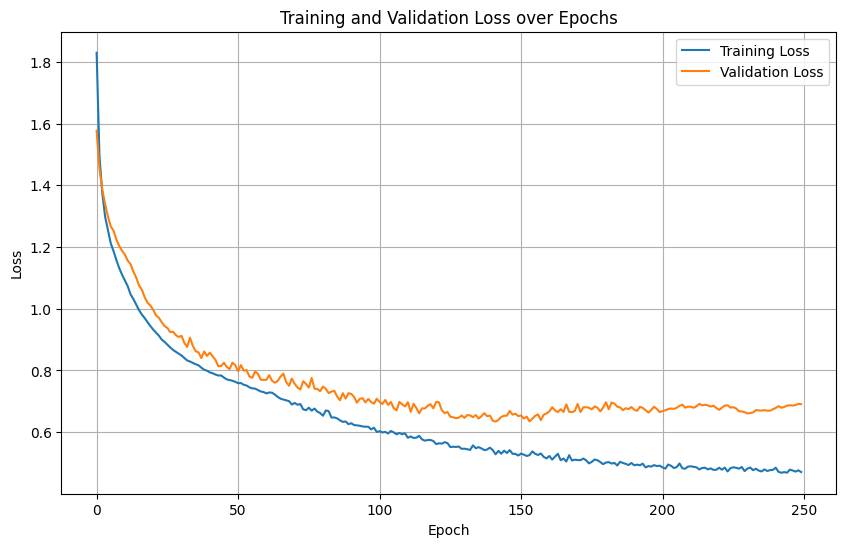

In [43]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(train_losses)), train_losses, label='Training Loss')
plt.plot(range(0, len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

**Plot Dice Score over Epochs**

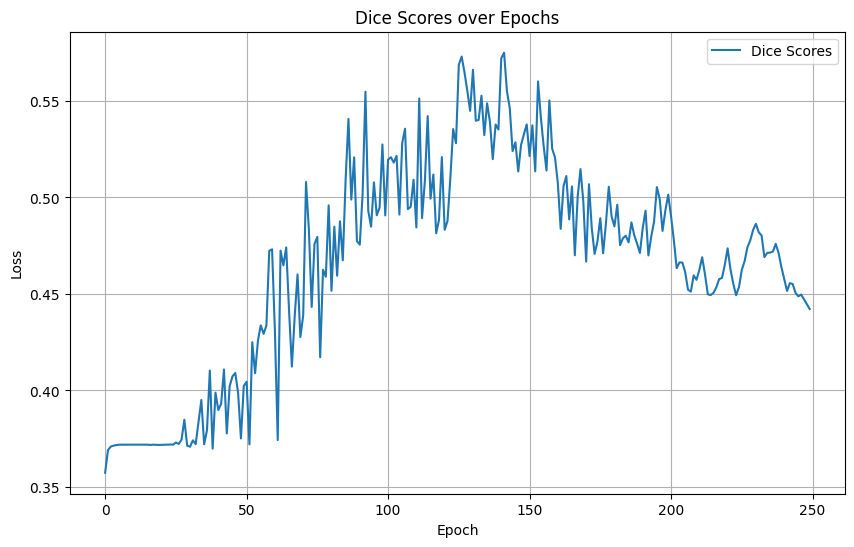

Highest Dice Score: 0.5749648809432983 at epoch 141


In [47]:
plt.figure(figsize=(10, 6))
plt.plot(range(0, len(dice_scores)), dice_scores, label='Dice Scores')
plt.title('Dice Scores over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Find the highest Dice score
highest_dice_score = max(dice_scores)
highest_epoch = dice_scores.index(highest_dice_score)

# Print the highest Dice score
print(f"Highest Dice Score: {highest_dice_score} at epoch {highest_epoch}")

**Plot Predicted Samples**

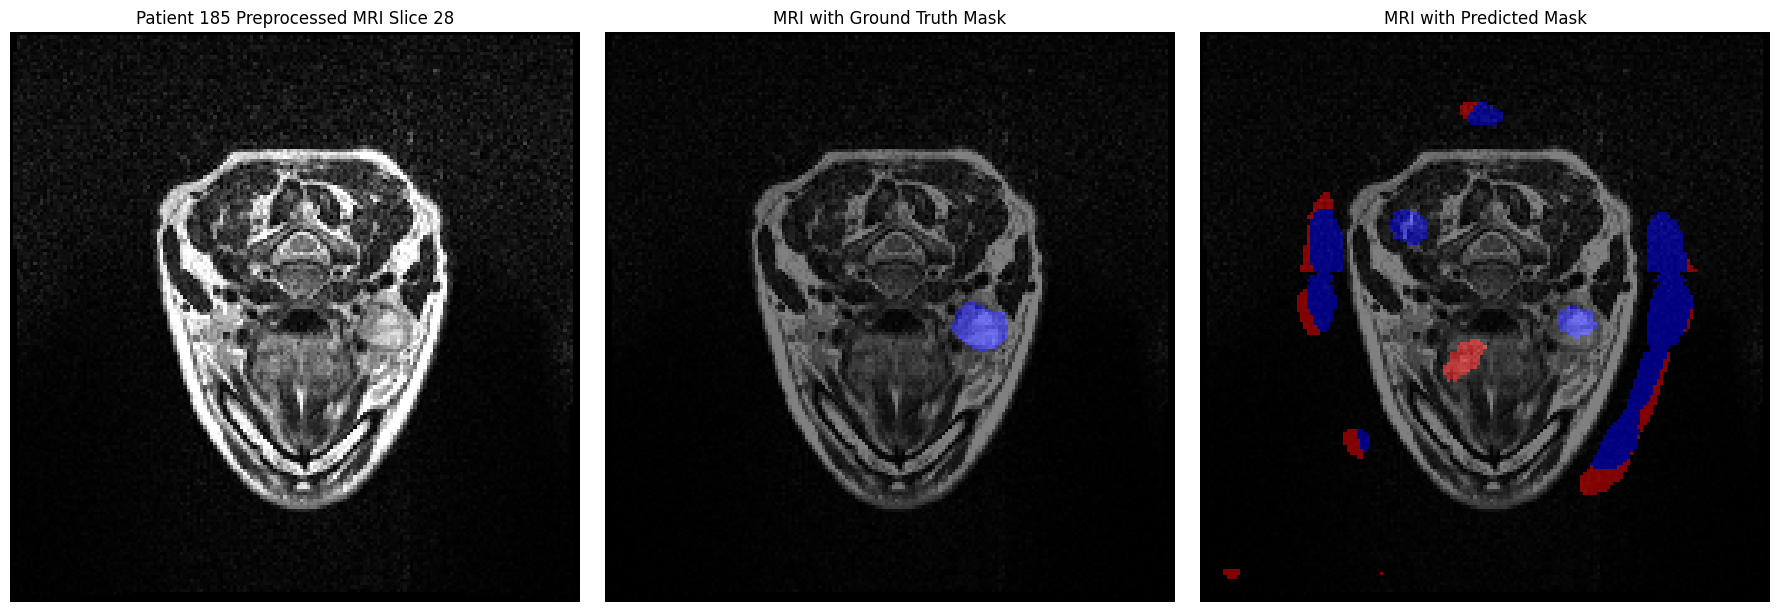

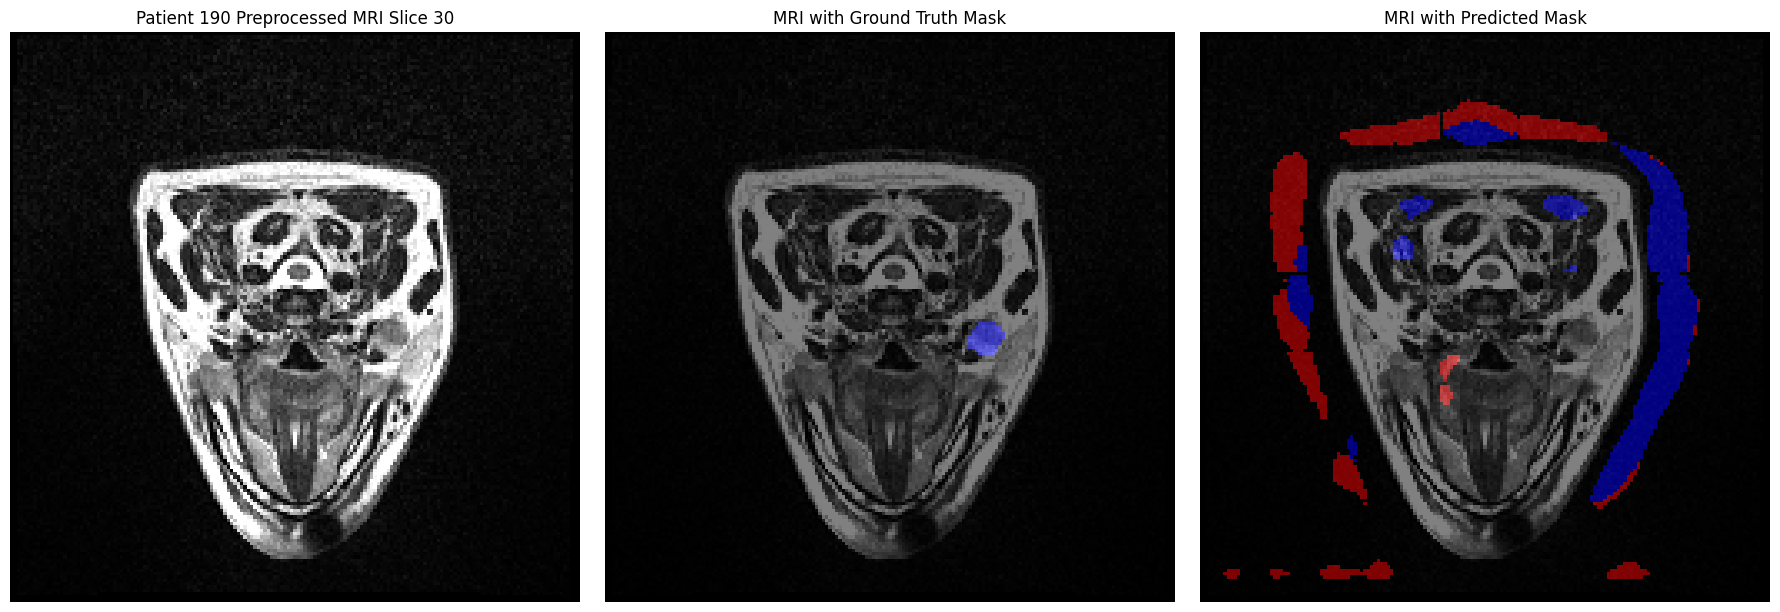

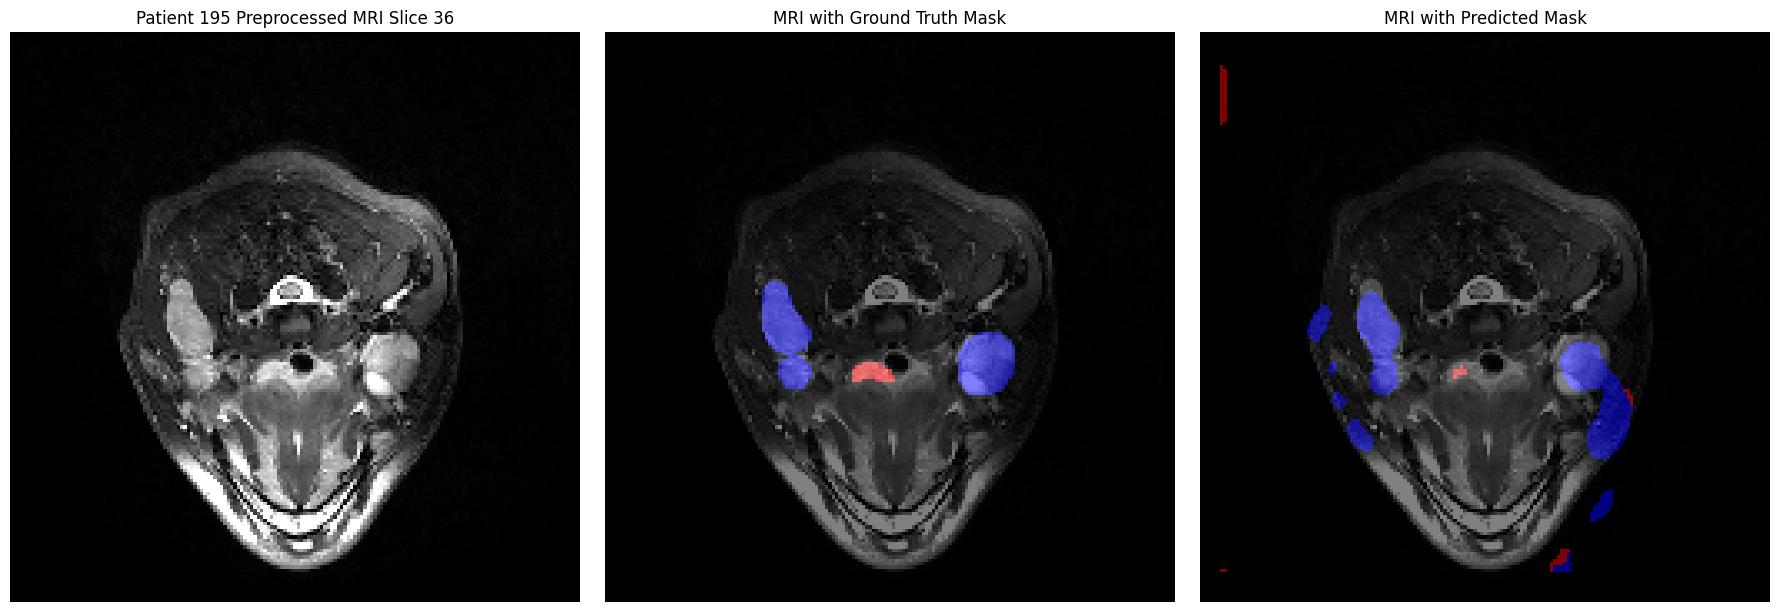

In [46]:
def plot_prediction(train_dir, val_transforms, model, patient_id, slice_index=None, device='cpu'):
    # Define paths
    mri_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_T2.nii.gz')
    mask_path = os.path.join(train_dir, patient_id, 'preRT', f'{patient_id}_preRT_mask.nii.gz')
    
    # Preprocess the image and label
    processed = val_transforms({"image": mri_path, "label": mask_path})
    preprocessed_image_tensor = processed["image"]
    preprocessed_label_tensor = processed["label"]

    # Convert tensors to numpy arrays
    preprocessed_image_np = preprocessed_image_tensor.cpu().numpy()
    preprocessed_label_np = preprocessed_label_tensor.cpu().numpy()

    # Remove channel dimension if present
    if preprocessed_image_np.shape[0] == 1:
        preprocessed_image_np = np.squeeze(preprocessed_image_np, axis=0)

    if preprocessed_label_np.ndim == 4 and preprocessed_label_np.shape[0] == 1:
        preprocessed_label_np = np.squeeze(preprocessed_label_np, axis=0)

    # Select middle slice if not specified
    if slice_index is None:
        slice_index = preprocessed_image_np.shape[2] // 2

    # Extract slices and transpose
    mri_slice = preprocessed_image_np[:, :, slice_index].T
    mask_slice = preprocessed_label_np[:, :, slice_index].T

    # Run the model to get predictions
    model.eval()
    with torch.no_grad():
        input_tensor = preprocessed_image_tensor.unsqueeze(0).to(device)
        with torch.amp.autocast(str(device)):
            output = sliding_window_inference(input_tensor, (96, 96, 96), 4, model)
            probabilities = torch.softmax(output, dim=1)
            predicted = torch.argmax(probabilities, dim=1).squeeze(0).cpu().numpy()
    
    # Extract the predicted slice and transpose
    predicted_slice = predicted[:, :, slice_index].T
    
    # Define colormap for mask
    cmap = colors.ListedColormap(['black', 'red', 'blue'])
    norm = colors.BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Preprocessed MRI Slice
    axes[0].imshow(mri_slice, cmap='gray', origin='upper')
    axes[0].set_title(f'Patient {patient_id} Preprocessed MRI Slice {slice_index}')
    axes[0].axis('off')

    # 2. MRI with Ground Truth Mask Overlay
    axes[1].imshow(mri_slice, cmap='gray', origin='upper')
    axes[1].imshow(mask_slice, cmap=cmap, norm=norm, alpha=0.5, origin='upper')
    axes[1].set_title('MRI with Ground Truth Mask')
    axes[1].axis('off')
    
    # 3. MRI with Predicted Mask Overlay
    axes[2].imshow(mri_slice, cmap='gray', origin='lower')
    axes[2].imshow(predicted_slice, cmap=cmap, norm=norm, alpha=0.5, origin='upper')
    axes[2].set_title('MRI with Predicted Mask')
    axes[2].axis('off')
    
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
# Ensure the model is on the correct device
model.to(device)

# Plot samples from a few patients
patient_ids = ['185','190','195']
for pid in patient_ids:
    plot_prediction(TRAIN_DIR, val_transforms, model, patient_id=pid, device=device)
